# Subspace outlier detection

In this notebook, I'm going to implement the outlier detection algorithm from Outlier Detection in Axis-Parallel Subspaces of High Dimensional Data, Kriegel et al., 2009.

* Original paper: [DOI](https://doi.org/10.1007/978-3-642-01307-2_86), [PDF](http://www.dbs.informatik.uni-muenchen.de/~zimek/publications/PAKDD2009/pakdd09-SOD.pdf)
* [Slides from PAKDD 2009](https://imada.sdu.dk/~zimek/publications/PAKDD2009/SOD-slides.pdf)

## Idea  behind SOD

For any given point, find a set of reference points, for example the nearest neighbors. Using a subset of the features, create a hyperplane along which the variance of the reference points is high. Then see how far from this hyperplane the point of interest is.

To put it another way, find the stable features for the reference points, then measure how far away the point of interest is from the reference points in these stable features. In the following image, SOD finds the green hyperplane (line), and measures the distance between the red point and the line to determine whether a point is an outlier.

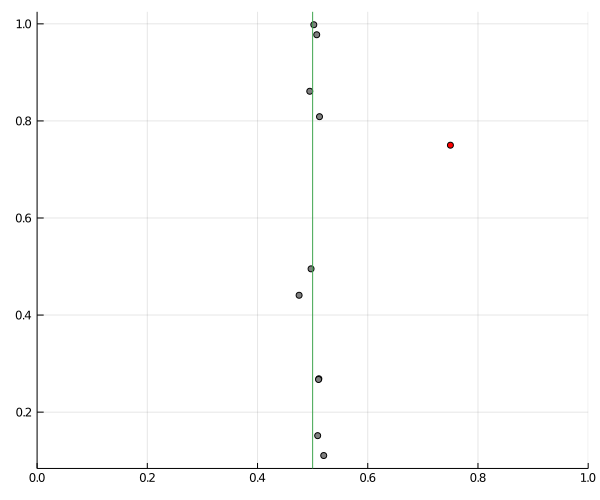

## Setup
Let's start by writing some functions we'll need for the outlier detection.

In [1]:
using Statistics

# find the features that make up the subspace, and the mean values of the reference points
function find_subspace(reference_points, cutoff, min_dim=5)
    variances = vec(var(reference_points, dims=1))
    
    # which features have large enough variances to make up the subspace?
    contributing_features = variances .> cutoff
    
    # if fewer than min_dim features fail to pass the threshold, use the min_dim features with lowest variance
    if sum(.!contributing_features) < min_dim
        indices = sortperm(variances)[1:min_dim]
        contributing_features[indices] .= false
    end
    
    # get the mean values of the features
    feature_means = mean(reference_points, dims=1)
    
    # in the paper, they set the features that don't contribute to 1, ie the negation
    return .!contributing_features, feature_means
end

# calculate the subspace outlier degree, which is the measure of outlier-ness
function subspace_outlier_degree(x, reference_points, cutoff)
    # get the subspace and means
    features, means = find_subspace(reference_points, cutoff)
    
    # distance between x and the subspace
    dist = sqrt(sum((x[features] - means[features]).^2))
    
    sod = dist / sum(features)
    return sod
end

function sod(data, neighbors, cutoff)
    n_points = size(data, 1)
    degree = [subspace_outlier_degree(data[i,:], data[neighbors[i,:],:], cutoff) for i in 1:n_points]
    return degree
end

# get all (squared) interpoint distances
function squared_interpoint_distances(data)
    n_points = size(data, 1)
    squared_dist = zeros(n_points, n_points)
    
    for i in 1:n_points
        for j in 1:i-1
            squared_dist[i,j] = sum((data[i,:] - data[j,:]).^2)
            squared_dist[j,i] = squared_dist[i,j]
        end
    end
    return squared_dist
end

# get every point's n nearest neighbors
function nearest_neighbors(dist, n)
    n_points = size(dist, 1)
    nn = zeros(Int32, n_points, n)
    
    for i in 1:n_points
        # get the distances for that specific point
        distances = dist[i,:]
    
        # sort the distances to other points, and return indices of n nearest neighbors
        # assumes that no 2 points occupy the exact same position in feature space
        nn[i,:] = sortperm(distances)[2:n+1]
    end
        
    return nn
end

# use shared nearest neighbors to stabilize the neighborhood (ie select better reference points)
function shared_nearest_neighbors(nn_matrix)
    n_points, n = size(nn_matrix)
    snn_weights = zeros(n_points, n_points)
    snn = zeros(Int32, n_points, n)
    
    for i in 1:n_points
        for j in 1:i-1
            common_neighbors = intersect(nn_matrix[i,:], nn_matrix[j,:])
            snn_weights[i,j] = length(common_neighbors)
            snn_weights[j,i] = snn_weights[i,j]
        end
    end
    
    for i in 1:n_points
        snn[i,:] = sortperm(snn_weights[i,:], rev=true)[2:n+1]
    end
    
    return snn
end

shared_nearest_neighbors (generic function with 1 method)

## The data

Now I'm going to load in some datasets with ground-truth outlier annotation from [ODDS](http://odds.cs.stonybrook.edu/). Specifically, I'll be using the following datasets:

| Dataset    | # points | # features | # outliers | reference                                                                                               |
|------------|----------|------------|------------|---------------------------------------------------------------------------------------------------------|
| Speech     | 3686     | 400        | 61         | [Sigillito et al.](https://www.jhuapl.edu/Content/techdigest/pdf/V10-N03/10-03-Sigillito_Class.pdf)     |
| Arrythmia  | 452      | 274        | 66         | [Micenkova et al.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.708.8377&rep=rep1&type=pdf) |
| Ionosphere | 351      | 33         | 126        | [Guvenir et al.](https://doi.org/10.1109/CIC.1997.647926)                                               |


In [2]:
# ODDS provides the datasets in .mat files, so I'll be using the MAT package to load them
using MAT

file=matopen("data/speech.mat")
speech=read(file)
close(file)

file=matopen("data/arrhythmia.mat")
arrythmia=read(file)
close(file)

file=matopen("data/ionosphere.mat")
ionosphere=read(file)
close(file)

# scale features to unit variance
for dataset in [speech arrythmia ionosphere]
    sdevs = std(dataset["X"], dims=1)
    
    # avoid division by zero
    sdevs[sdevs.==0] .= 1
    
    dataset["X"] = dataset["X"] ./ sdevs
end

## Let's detect some outliers

I'll use the ROC curves to see how well the method does at finding real outliers.

In [3]:
using Gadfly, DataFrames, Cairo, Fontconfig
Gadfly.set_default_plot_size(24cm, 18cm)

# get the area under the curve
function area_under_curve(fpr, tpr)
    auc = 0
    for i in 1:length(fpr)-1
        auc = auc + (fpr[i+1] - fpr[i]) * tpr[i]
    end
    
    auc = auc + (1 - last(fpr)) * last(tpr)
    
    return auc
end

function roc(outlier_degree, truth)
    # first, we sort the data points by their outlier-ness
    outlierness_order = sortperm(outlier_degree, rev=true)
    
    # the true positive rate is the truth ordered by outlierness_order
    tpr = cumsum(truth[outlierness_order])
    fpr = cumsum(.!truth[outlierness_order])
    
    tpr = tpr / sum(truth .== 1)
    fpr = fpr / sum(truth .== 0)
    
    auc = area_under_curve(fpr, tpr)
    
    return tpr, fpr, auc
end

# create empty dataframe to store results
df = DataFrame()
df_auc = DataFrame(method=[], dataset=[], n_neighbors=[], alpha=[], auc=[])

# loop first over num neighbors, then alpha
for n in [5 10 15]
    for cutoff in [0.3 0.5 1]
        for (dataset, name) in zip([speech arrythmia ionosphere], ["speech" "arrythmia" "ionosphere"])
            dist = squared_interpoint_distances(dataset["X"])
            nn = nearest_neighbors(dist, n)
            snn = shared_nearest_neighbors(nn)
            
            degree = sod(dataset["X"], snn, cutoff)
            
            tpr, fpr, auc = roc(degree, dataset["y"].==1)
            
            df_temp=DataFrame(tpr=tpr, fpr=fpr, n_neighbors="$n", alpha=cutoff, dataset=name)
            append!(df, df_temp)
            
            # add auc results to df
            push!(df_auc, ["SOD" name n cutoff auc])
        end
    end
end

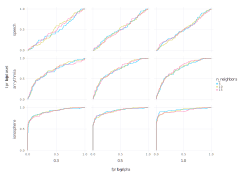

In [4]:
# let's plot the results
# we have false positive rate on the x-axis and true positive rate on the y-axis
p = plot(df, x=:fpr, y=:tpr, color=:n_neighbors, xgroup=:alpha, ygroup=:dataset, Geom.subplot_grid(Geom.step))
# draw(PNG("images/sod-roc.png", 8inch, 6inch, dpi=300), p)

In [5]:
df_auc

27×5 DataFrame
│ Row │ method │ dataset    │ n_neighbors │ alpha │ auc      │
│     │ Any    │ Any        │ Any         │ Any   │ Any      │
├─────┼────────┼────────────┼─────────────┼───────┼──────────┤
│ 1   │ SOD    │ speech     │ 5           │ 0.3   │ 0.484468 │
│ 2   │ SOD    │ arrythmia  │ 5           │ 0.3   │ 0.688413 │
│ 3   │ SOD    │ ionosphere │ 5           │ 0.3   │ 0.907125 │
│ 4   │ SOD    │ speech     │ 5           │ 0.5   │ 0.517373 │
│ 5   │ SOD    │ arrythmia  │ 5           │ 0.5   │ 0.708549 │
│ 6   │ SOD    │ ionosphere │ 5           │ 0.5   │ 0.917143 │
│ 7   │ SOD    │ speech     │ 5           │ 1.0   │ 0.510214 │
│ 8   │ SOD    │ arrythmia  │ 5           │ 1.0   │ 0.732964 │
│ 9   │ SOD    │ ionosphere │ 5           │ 1.0   │ 0.937989 │
│ 10  │ SOD    │ speech     │ 10          │ 0.3   │ 0.511643 │
⋮
│ 17  │ SOD    │ arrythmia  │ 10          │ 1.0   │ 0.743641 │
│ 18  │ SOD    │ ionosphere │ 10          │ 1.0   │ 0.930723 │
│ 19  │ SOD    │ speech     │ 15          │ 0.3   │ 0.509861 │
│ 20  │ SOD    │ arrythmia  │ 15          │ 0.3   │ 0.685665 │
│ 21  │ SOD    │ ionosphere │ 15          │ 0.3   │ 0.903316 │
│ 22  │ SOD    │ speech     │ 15          │ 0.5   │ 0.504063 │
│ 23  │ SOD    │ arrythmia  │ 15          │ 0.5   │ 0.723936 │
│ 24  │ SOD    │ ionosphere │ 15          │ 0.5   │ 0.916614 │
│ 25  │ SOD    │ speech     │ 15          │ 1.0   │ 0.499853 │
│ 26  │ SOD    │ arrythmia  │ 15          │ 1.0   │ 0.758243 │
│ 27  │ SOD    │ ionosphere │ 15          │ 1.0   │ 0.91746  │

## Outlier detection using PCA hyperplanes

The concept of subspace outlier detection suggests a simple modification: what if we use a PCA to create a variance-maximizing hyperplane fit to the reference points, and measure the distance to the point of interest? In other words, instead of creating a hyperplane using a subset of features, we create the hyperplane using combinations of all features (using PCA).

To explain it using images, SOD, creates a hyperplane (line) along the axis that the reference point features vary the most:

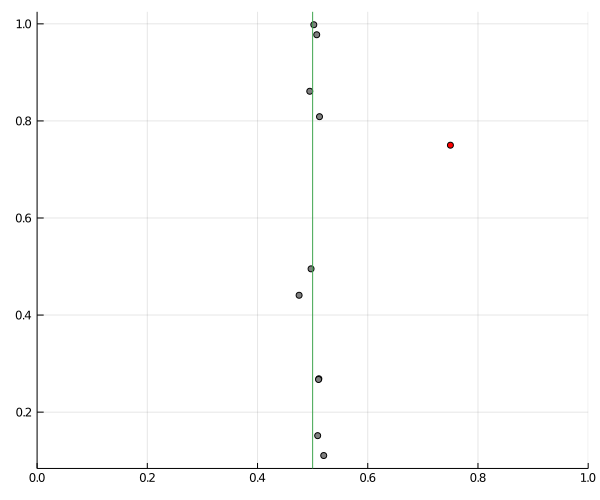

and then measures the distance between that line and the point of interest. PCA outlier detection creates a hyperplane (line) that maximizes the variance of the reference point features:

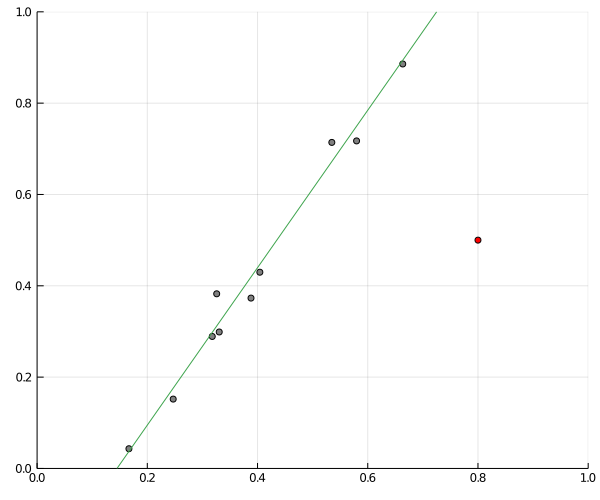

Unlike SOD, the hyperplane does not need to be parallel to the feature axes. Unlike SOD, the hyperplane does not need to be parallel to the feature axes. In theory, this makes PCA outlier detection more flexible and thus useful for a greater range of datasets.

Let's see if it works.

In [6]:
using MultivariateStats

function pca_outlier_degree(x, reference_points, npcs=10)
    # fit a hyperplane using PCA
    ref_means = vec(mean(reference_points, dims=1))
    pca=fit(PCA, transpose(reference_points), maxoutdim=npcs, mean=ref_means)
    
    proj = projection(pca)
    
    # get the distance between x and the PCA hyperplane, ie the distance between x and its projection
    # first, project onto PCA space
    transformed = transpose(proj) * (x - ref_means)
    
    # next, get coordinates of projected point in original space
    projected = (proj * transformed) + ref_means
    
    # then get the difference
    projection_difference = x - projected
    
    # calculate the norm of the projection length
    dist = sqrt(sum(projection_difference.^2))
    
    return dist
end

function pcaod(data, neighbors, npcs)
    n_points = size(data, 1)
    degree = [pca_outlier_degree(data[i,:], data[neighbors[i,:],:], npcs) for i in 1:n_points]
    return degree
end

# create empty dataframe to store results
df_pca = DataFrame()
df_auc_pca = DataFrame(method=[], dataset=[], n_neighbors=[], npcs=[], auc=[])

# loop first over num neighbors, then num PCs
for n in [5 10 15]
    for npcs in [5 10 20]
        for (dataset, name) in zip([speech arrythmia ionosphere], ["speech" "arrythmia" "ionosphere"])
            dist = squared_interpoint_distances(dataset["X"])
            nn = nearest_neighbors(dist, n)
            snn = shared_nearest_neighbors(nn)
            
            degree = pcaod(dataset["X"], snn, npcs)
            
            tpr, fpr, auc = roc(degree, dataset["y"].==1)
            
            df_temp=DataFrame(tpr=tpr, fpr=fpr, n_neighbors="$n", npcs=npcs, dataset=name)
            append!(df_pca, df_temp)
            
            # add auc results to df
            push!(df_auc_pca, ["SOD" name n npcs auc])
        end
    end
end

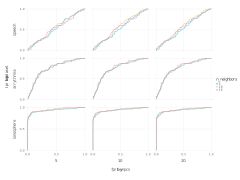

In [7]:
# again, false positive rate on x-axis, true positive rate on y-axis
q=plot(df_pca, x=:fpr, y=:tpr, color=:n_neighbors, xgroup=:npcs, ygroup=:dataset, Geom.subplot_grid(Geom.step))
# draw(PNG("images/pcaod-roc.png", 8inch, 6inch, dpi=300), q)

In [8]:
df_auc_pca

27×5 DataFrame
│ Row │ method │ dataset    │ n_neighbors │ npcs │ auc      │
│     │ Any    │ Any        │ Any         │ Any  │ Any      │
├─────┼────────┼────────────┼─────────────┼──────┼──────────┤
│ 1   │ SOD    │ speech     │ 5           │ 5    │ 0.534051 │
│ 2   │ SOD    │ arrythmia  │ 5           │ 5    │ 0.749293 │
│ 3   │ SOD    │ ionosphere │ 5           │ 5    │ 0.938801 │
│ 4   │ SOD    │ speech     │ 5           │ 10   │ 0.534051 │
│ 5   │ SOD    │ arrythmia  │ 5           │ 10   │ 0.749293 │
│ 6   │ SOD    │ ionosphere │ 5           │ 10   │ 0.938801 │
│ 7   │ SOD    │ speech     │ 5           │ 20   │ 0.534051 │
│ 8   │ SOD    │ arrythmia  │ 5           │ 20   │ 0.749293 │
│ 9   │ SOD    │ ionosphere │ 5           │ 20   │ 0.938801 │
│ 10  │ SOD    │ speech     │ 10          │ 5    │ 0.54963  │
⋮
│ 17  │ SOD    │ arrythmia  │ 10          │ 20   │ 0.7584   │
│ 18  │ SOD    │ ionosphere │ 10          │ 20   │ 0.936614 │
│ 19  │ SOD    │ speech     │ 15          │ 5    │ 0.537538 │
│ 20  │ SOD    │ arrythmia  │ 15          │ 5    │ 0.760912 │
│ 21  │ SOD    │ ionosphere │ 15          │ 5    │ 0.953898 │
│ 22  │ SOD    │ speech     │ 15          │ 10   │ 0.551991 │
│ 23  │ SOD    │ arrythmia  │ 15          │ 10   │ 0.76048  │
│ 24  │ SOD    │ ionosphere │ 15          │ 10   │ 0.943951 │
│ 25  │ SOD    │ speech     │ 15          │ 20   │ 0.558639 │
│ 26  │ SOD    │ arrythmia  │ 15          │ 20   │ 0.759931 │
│ 27  │ SOD    │ ionosphere │ 15          │ 20   │ 0.944303 │

## Conclusions

SOD and PCAOD seem to achieve pretty similar results on ionosphere and arrythmia, with PCAOD perhaps having a slight edge. Interestingly, neither method finds outliers with any real success on the speech dataset; my guess is that you might need nonlinear models there.

Choices of alpha, n_neighbors and npcs seem to have a minor impact on results. 